In [1]:
import matplotlib
matplotlib.use('nbagg')
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
%load_ext vplants.autowig.rich_display
%load_ext pyclanglite.rich_display

In [3]:
from vplants.autowig.asg import AbstractSemanticGraph
from vplants.autowig.scons import *
from time import time
asg = AbstractSemanticGraph()

In [4]:
from vplants.autowig.front_end import front_end
from pyclanglite_plugin.autowig import PyClangLiteFrontEndPlugin
front_end['pyclanglite'] = PyClangLiteFrontEndPlugin
front_end.plugin = 'pyclanglite'

bootstrap
94
1 12254 14304
52
2 14304 14635
14
3 14635 14635


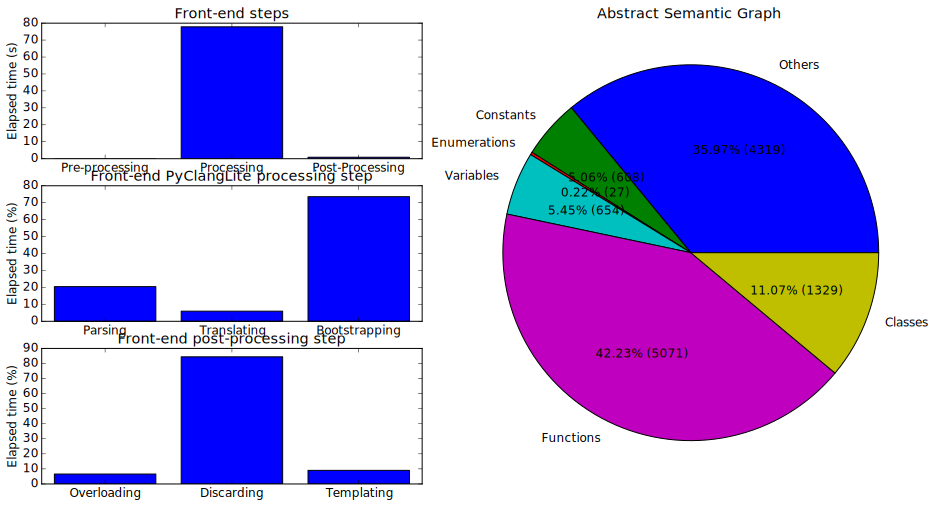

In [5]:
from path import path
includedir = "../../statiskit/core/build-scons/include"
headers = list(path(includedir).walkfiles('*.h'))

flags = ['-x', 'c++', '-g', '-std=c++11', '-stdlib=libstdc++',
         '-I/usr/include', '-I' + includedir, '-I/usr/include/eigen3',
         '-I/usr/include/eigen3/unsupported', '-D__STDC_CONSTANT_MACROS',
         '-I/usr/local/lib/clang/3.7.0/include', '-D__STDC_LIMIT_MACROS']

front_end(asg, headers, flags=flags, silent=True,
          force_overload=True, bootstrap=True)

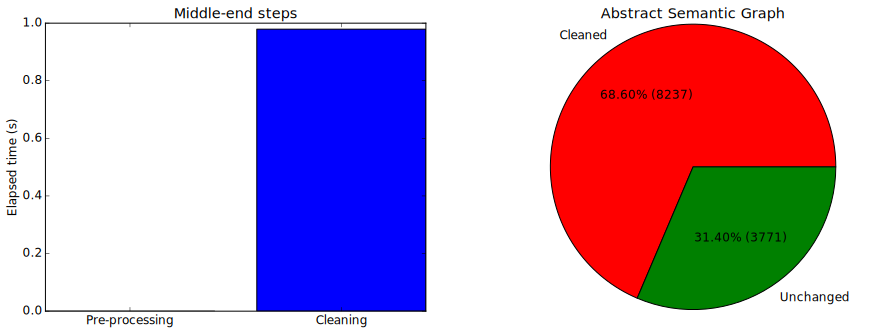

In [6]:
from vplants.autowig.middle_end import middle_end
primaries = [header for header in asg.files(header=True) if header.is_primary]
for hdr in asg.files(header=True):
    if not hdr.is_primary and hdr.include in primaries:
        hdr.is_primary = True
middle_end(asg)

In [7]:
from vplants.autowig.back_end import back_end
pattern = '^(.*)statiskit(.*)'
filename =  '../../statiskit/core/src/wrapper/statiskit_core.cpp'
target = '../../statiskit/core/src/statiskit/core'
held_type = 'class ::boost::shared_ptr'
#for spc in asg['class ::statiskit::ElementaryEvent'].specializations():
#    spc.boost_python_export = False
#for tdf in asg.nodes('::statiskit::(Categorical|Discrete|Continuous)ElementaryEvent'):
#    tdf.boost_python_export = False
#asg.functions('::statiskit::get_random_generator').pop().boost_python_export = False
asg['::statiskit'].boost_python_export = False
back_end(asg, filename, target=target, pattern=pattern, held_type=held_type)

Total files generated in memory,68 (f)
Total source lines of code,1336 (l)
Elapsed time,0.9 (s)
Development effort estimate,4.15 (p.m)
Schedule estimate,4.11 (m)
Estimated average number of developers,1.01 (p)


In [8]:
bpe = asg[filename].add_boost_python_export('../../statiskit/core/src/wrapper/converter_event.cpp')
#bpe.content = '#include <boost/python.hpp>\n#include <statiskit/core/event.h>\n\ntemplate<class E>\nstruct elementary_from_python\n{\n    elementary_from_python()\n    {\n        boost::python::converter::registry::push_back(&convertible, &construct,\n            boost::python::type_id< ::statiskit::ElementaryEvent< E > >());\n    }\n\n    static void* convertible(PyObject* obj_ptr)\n    { return obj_ptr; }\n    \n    static void construct(PyObject* obj_ptr, boost::python::converter::rvalue_from_python_stage1_data* data)\n    {\n        const typename E::value_type outcome = boost::python::extract< typename E::value_type >(obj_ptr);\n        assert(outcome);\n        void* storage = ((boost::python::converter::rvalue_from_python_storage< ::statiskit::ElementaryEvent< E > >*)data)->storage.bytes;\n        new (storage) ::statiskit::ElementaryEvent< E >(outcome);\n        data->convertible = storage;\n    }\n};\n\nvoid converter_event()\n{\n    elementary_from_python< ::statiskit::CategoricalEvent >();\n    elementary_from_python< ::statiskit::DiscreteEvent >();\n    elementary_from_python< ::statiskit::ContinuousEvent >();\n}\n'
#for spc in asg['class ::statiskit::ElementaryEvent'].specializations():
#    bpe.add_wrap(spc)

In [9]:
asg[filename].append_unique = dict(LIBS = ['statiskit_core'])
from vplants.autowig.boost_python_back_end import closure
closure(asg)
asg['::statiskit'].boost_python_export = False
#for tdf in asg.nodes('::statiskit::(Categorical|Discrete|Continuous)ElementaryEvent'):
#    tdf.boost_python_export = False

In [10]:
pattern = '^(class |struct )::std::(vector|set|map|pair)<(.*)statiskit(.*)>$'
for node in asg.nodes(pattern):
    for ctr in node.constructors:
        ctr.boost_python_export = False
back_end(asg, filename, target=target, pattern=pattern, held_type=held_type)

Total files generated in memory,69 (f)
Total source lines of code,1325 (l)
Elapsed time,0.67 (s)
Development effort estimate,4.11 (p.m)
Schedule estimate,4.1 (m)
Estimated average number of developers,1.0 (p)


In [11]:
for f in asg.directories('(.*)boost/$').pop().files:
    f.is_primary = True
pattern = '(.*)'
for mtd in asg.functions('::std::(set|vector|map|basic_string)<(.*)>::operator\[\]', free=False):
    mtd.boost_python_export = False
filename =  '../../miscxx/src/wrapper/miscxx.cpp'
target = '../../miscxx/src/miscxx'
asg['class ::std::_Rb_tree_const_iterator'].is_smart_pointer = False
back_end(asg, filename, target=target, pattern=pattern, held_type=held_type)

Total files generated in memory,52 (f)
Total source lines of code,1408 (l)
Elapsed time,0.83 (s)
Development effort estimate,4.4 (p.m)
Schedule estimate,4.2 (m)
Estimated average number of developers,1.05 (p)


In [12]:
asg[filename].append_unique = dict(CPPPATH = [inc.globalname for inc in asg.directories() if inc.as_include])

In [13]:
back_end.plugin = 'boost_python:on_disk'
back_end(asg)

Total files generated on disk,126 (f)
Total source lines of code,3180 (l)
Elapsed time,1.45 (s)
Development effort estimate,10.96 (p.m)
Schedule estimate,5.78 (m)
Estimated average number of developers,1.9 (p)


In [14]:
asg.add_sconstruct('../../miscxx')
asg.scons('-j', '2')

In [15]:
asg.add_sconstruct('../../statiskit/core')
asg.scons('-j', '2')

In [16]:
f = asg.functions('::std::vector<unsigned int(.*)::begin').pop()

In [17]:
f.result_type.target.methods()

[::__gnu_cxx::__normal_iterator<const unsigned int *, std::vector<unsigned int, std::allocator<unsigned int> > >::operator*::074f912f-a135-5440-b68e-b6fce6931821,
 ::__gnu_cxx::__normal_iterator<const unsigned int *, std::vector<unsigned int, std::allocator<unsigned int> > >::operator->::14ff05c4-7b9b-5b11-9f2c-71ffaa763c9b,
 ::__gnu_cxx::__normal_iterator<const unsigned int *, std::vector<unsigned int, std::allocator<unsigned int> > >::operator++::b8cb8b81-591b-5d18-892a-a685c25c8257,
 ::__gnu_cxx::__normal_iterator<const unsigned int *, std::vector<unsigned int, std::allocator<unsigned int> > >::operator++::029de76b-f9ab-50b3-9c5f-141185e2f7e3,
 ::__gnu_cxx::__normal_iterator<const unsigned int *, std::vector<unsigned int, std::allocator<unsigned int> > >::operator--::65668fc0-9eb3-5250-b609-6f187b432a5a,
 ::__gnu_cxx::__normal_iterator<const unsigned int *, std::vector<unsigned int, std::allocator<unsigned int> > >::operator--::8698ee79-a812-5167-b250-b460260c7c2a,
 ::__gnu_cxx::__n

In [18]:
asg['class ::__gnu_cxx::__normal_iterator'].is_smart_pointer

True

In [19]:
for bpe in asg.boost_python_modules('(.*)miscxx(.*)').pop().boost_python_exports:
    print bpe.wraps

[class ::std::exception]
[class ::std::basic_string<char, std::char_traits<char>, std::allocator<char> >]
[struct ::std::_Rb_tree_const_iterator<std::basic_string<char> >]
[union ::std::aligned_storage<8, 8>::type]
[struct ::std::pair<std::_Rb_tree_const_iterator<int>, bool>]
[struct ::std::_Rb_tree_node_base]
[struct ::std::pair<std::_Rb_tree_const_iterator<double>, std::_Rb_tree_const_iterator<double> >]
[class ::std::set<std::basic_string<char>, std::less<std::basic_string<char> >, std::allocator<std::basic_string<char> > >]
[union ::std::aligned_storage<16, 8>::type]
[enum ::std::_Rb_tree_color]
[class ::__gnu_cxx::new_allocator<char>]
[class ::std::set<int, std::less<int>, std::allocator<int> >]
[class ::__gnu_cxx::new_allocator, class ::__gnu_cxx::__normal_iterator, class ::__gnu_cxx::__aligned_buffer]
[class ::boost::random::mersenne_twister_engine<unsigned int, 32, 624, 397, 31, 2567483615, 11, 4294967295, 7, 2636928640, 15, 4022730752, 18, 1812433253>]
[struct ::std::aligned_s